In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from datetime import datetime, timedelta
pd.set_option('display.float_format', '{:.2f}'.format)


**1. Load dataset and check data**

In [ ]:
data = pd.read_csv('RealEstateAU_1000_Samples.csv')
df = pd.DataFrame(data)
df.head()

,index,TID,breadcrumb,category_name,property_type,building_size,land_size,preferred_size,open_date,listing_agency,...,state,zip_code,phone,latitude,longitude,product_depth,bedroom_count,bathroom_count,parking_count,RunDate
0,0,1350988,Buy>NT>DARWIN CITY,Real Estate & Property for sale in DARWIN CITY...,House,NaN,NaN,NaN,Added 2 hours ago,Professionals - DARWIN CITY,...,NT,800,08 8941 8289,NaN,NaN,premiere,2.00,1.00,1.00,2022-05-27 15:54:05
1,1,1350989,Buy>NT>DARWIN CITY,Real Estate & Property for sale in DARWIN CITY...,Apartment,171m²,NaN,171m²,Added 7 hours ago,Nick Mousellis Real Estate - Eview Group Member,...,NT,800,0411724000,NaN,NaN,premiere,3.00,2.00,2.00,2022-05-27 15:54:05
2,2,1350990,Buy>NT>DARWIN CITY,Real Estate & Property for sale in DARWIN CITY...,Unit,NaN,NaN,NaN,Added 22 hours ago,Habitat Real Estate - THE GARDENS,...,NT,800,08 8981 0080,NaN,NaN,premiere,2.00,1.00,1.00,2022-05-27 15:54:05
3,3,1350991,Buy>NT>DARWIN CITY,Real Estate & Property for sale in DARWIN CITY...,House,NaN,NaN,NaN,Added yesterday,Ray White - NIGHTCLIFF,...,NT,800,08 8982 2403,NaN,NaN,premiere,1.00,1.00,0.00,2022-05-27 15:54:05
4,4,1350992,Buy>NT>DARWIN CITY,Real Estate & Property for sale in DARWIN CITY...,Unit,201m²,NaN,201m²,Added yesterday,Carol Need Real Estate - Fannie Bay,...,NT,800,0418885966,NaN,NaN,premiere,3.00,2.00,2.00,2022-05-27 15:54:05


2. **Checking missing value**

In [ ]:
df.isna().sum()

,0
index,0
TID,0
breadcrumb,0
category_name,0
property_type,0
building_size,720
land_size,467
preferred_size,391
open_date,698
listing_agency,0


- As we see, There is no values in latitude and longtitude. Therefore, we will drop it.
- The variables for building size, land size, preferred size, and open date have a relatively high proportion of missing values. While these data points won't be excluded, it is important to handle them carefully in the analysis.
- The rest of the variables have minimal missing data, allowing them to be utilized in our analysis with little concern

**3. Data cleaning**

**3.1 Feature Selection**
- In this stage, we will retain key variables that are likely to provide significant insights in our analysis. Variables from the following categories will be excluded from the dataset:

  - Variables that do not offer meaningful insights, such as index, TID, breadcrumb, phone, and product_depth.
  - Variables with a large proportion of missing values, including latitude and longitude.
  - Redundant columns that contain identical data, for instance, both Price and location_name represent the property's price, so location_name will be removed.

In [ ]:
remove_variables = [
    "index", "TID", "breadcrumb", "phone", "product_depth",
    "latitude", "longitude", "location_name", "address",
    "RunDate", "category_name", "location_type"
]

# Check if all columns exist before dropping
missing_columns = [col for col in remove_variables if col not in df.columns]
if missing_columns:
    print(f"Warning: The following columns are not in the DataFrame: {missing_columns}")
#Dropping the specified columns that exist
existing_columns_to_drop = [col for col in remove_variables if col in df.columns]
df = df.drop(columns=existing_columns_to_drop)
df.head()


,property_type,building_size,land_size,preferred_size,open_date,listing_agency,price,location_number,address_1,city,state,zip_code,bedroom_count,bathroom_count,parking_count
0,House,NaN,NaN,NaN,Added 2 hours ago,Professionals - DARWIN CITY,"$435,000",139468611,44 Woods Street,Darwin City,NT,800,2.00,1.00,1.00
1,Apartment,171m²,NaN,171m²,Added 7 hours ago,Nick Mousellis Real Estate - Eview Group Member,"Offers Over $320,000",139463755,14/14 Dashwood Place,Darwin City,NT,800,3.00,2.00,2.00
2,Unit,NaN,NaN,NaN,Added 22 hours ago,Habitat Real Estate - THE GARDENS,"$310,000",139462495,13/86 Woods Street,Darwin City,NT,800,2.00,1.00,1.00
3,House,NaN,NaN,NaN,Added yesterday,Ray White - NIGHTCLIFF,"$259,000",139451679,1309/43B Knuckey Street,Darwin City,NT,800,1.00,1.00,0.00
4,Unit,201m²,NaN,201m²,Added yesterday,Carol Need Real Estate - Fannie Bay,"$439,000",139433803,3/10 McLachlan Street,Darwin City,NT,800,3.00,2.00,2.00


**3.2 Building, Land, and Preferred Size**
- Variables associated with property and land sizes will be cleaned and converted into numerical data types for consistency.

In [ ]:
def clean_size_column(column):
    #Extracting numeric values and handling multiple matches
    extracted_values = column.str.extractall('([0-9]+)')[0].unstack().fillna(0)
    #Converting to numeric and summing across matches for each row
    #Apply pd.to_numeric to each column of the DataFrame
    numeric_values = extracted_values.apply(pd.to_numeric, errors='coerce')
    return numeric_values.sum(axis=1)

df['building_size'] = clean_size_column(df['building_size'])
df['land_size'] = clean_size_column(df['land_size'])
df['preferred_size'] = clean_size_column(df['preferred_size'])

df.head()

,property_type,building_size,land_size,preferred_size,open_date,listing_agency,price,location_number,address_1,city,state,zip_code,bedroom_count,bathroom_count,parking_count
0,House,NaN,NaN,NaN,Added 2 hours ago,Professionals - DARWIN CITY,"$435,000",139468611,44 Woods Street,Darwin City,NT,800,2.00,1.00,1.00
1,Apartment,171.00,NaN,171.00,Added 7 hours ago,Nick Mousellis Real Estate - Eview Group Member,"Offers Over $320,000",139463755,14/14 Dashwood Place,Darwin City,NT,800,3.00,2.00,2.00
2,Unit,NaN,NaN,NaN,Added 22 hours ago,Habitat Real Estate - THE GARDENS,"$310,000",139462495,13/86 Woods Street,Darwin City,NT,800,2.00,1.00,1.00
3,House,NaN,NaN,NaN,Added yesterday,Ray White - NIGHTCLIFF,"$259,000",139451679,1309/43B Knuckey Street,Darwin City,NT,800,1.00,1.00,0.00
4,Unit,201.00,NaN,201.00,Added yesterday,Carol Need Real Estate - Fannie Bay,"$439,000",139433803,3/10 McLachlan Street,Darwin City,NT,800,3.00,2.00,2.00


**3.3 Price**
- The price variable will be cleaned and convertd to numarical variable.

In [ ]:
#Convert all entries in the price column to strings before cleaning
df_oz_clean = df.copy()
df_oz_clean['price'] = df_oz_clean['price'].astype(str).str.replace(r'\D', '', regex=True)
#Convert to numerical varaible
df_oz_clean['price'] = pd.to_numeric(df_oz_clean['price'], errors='coerce')

**3.4 Address**
- Since the exact unit address does not offer extra useful information, we will retain only the street address.

In [ ]:
#Remove all non-alphabetic characters from address_1 and clean stop words
def clean_address(address):
    #Check if the address is NaN, if so, return an empty string
    if pd.isna(address):
        return ''
    #Remove non-alphabetic characters and convert to string
    cleaned_address = re.sub(r'[^a-zA-Z]', ' ', str(address))
    #Remove specific stop words
    stop_words = ["Lot", "Unit", "UNIT"]
    for word in stop_words:
        cleaned_address = re.sub(r'\b' + word + r'\b', '', cleaned_address)
    #Remove extra whitespace
    cleaned_address = ' '.join(cleaned_address.split())
    return cleaned_address

#Apply the clean_address function
df_oz_clean['address_1'] = df_oz_clean['address_1'].apply(clean_address)

#Rename 'address_1' column to 'street_address'
df_oz_clean.rename(columns={'address_1': 'street_address'}, inplace=True)

df_oz_clean.head()

,property_type,building_size,land_size,preferred_size,open_date,listing_agency,price,location_number,street_address,city,state,zip_code,bedroom_count,bathroom_count,parking_count
0,House,NaN,NaN,NaN,Added 2 hours ago,Professionals - DARWIN CITY,435000.00,139468611,Woods Street,Darwin City,NT,800,2.00,1.00,1.00
1,Apartment,171.00,NaN,171.00,Added 7 hours ago,Nick Mousellis Real Estate - Eview Group Member,320000.00,139463755,Dashwood Place,Darwin City,NT,800,3.00,2.00,2.00
2,Unit,NaN,NaN,NaN,Added 22 hours ago,Habitat Real Estate - THE GARDENS,310000.00,139462495,Woods Street,Darwin City,NT,800,2.00,1.00,1.00
3,House,NaN,NaN,NaN,Added yesterday,Ray White - NIGHTCLIFF,259000.00,139451679,B Knuckey Street,Darwin City,NT,800,1.00,1.00,0.00
4,Unit,201.00,NaN,201.00,Added yesterday,Carol Need Real Estate - Fannie Bay,439000.00,139433803,McLachlan Street,Darwin City,NT,800,3.00,2.00,2.00


**3.5 Open date**
- We will use a reference date of 29th November, 2022 (Date of dataset upload on Kaggle) has been chosen.

In [ ]:
#Reference date of the dataset upload on Kaggle
reference_date = datetime(2022, 11, 29)

#Convert 'Added yesterday' to '1'
df_oz_clean['open_date'] = df_oz_clean['open_date'].replace('Added yesterday', '1')

#Convert any entry containing 'hour' to '0'
df_oz_clean['open_date'] = df_oz_clean['open_date'].apply(lambda x: '0' if 'hour' in str(x) else x)

#Remove non-numeric characters and convert to numeric
df_oz_clean['open_date'] = pd.to_numeric(df_oz_clean['open_date'].str.replace(r'\D', '', regex=True), errors='coerce')

#Calculate actual dates based on the reference date
df_oz_clean['open_date'] = reference_date - pd.to_timedelta(df_oz_clean['open_date'], unit='D')

# Display the cleaned DataFrame
df_oz_clean.head()

,property_type,building_size,land_size,preferred_size,open_date,listing_agency,price,location_number,street_address,city,state,zip_code,bedroom_count,bathroom_count,parking_count
0,House,NaN,NaN,NaN,2022-11-29,Professionals - DARWIN CITY,435000.00,139468611,Woods Street,Darwin City,NT,800,2.00,1.00,1.00
1,Apartment,171.00,NaN,171.00,2022-11-29,Nick Mousellis Real Estate - Eview Group Member,320000.00,139463755,Dashwood Place,Darwin City,NT,800,3.00,2.00,2.00
2,Unit,NaN,NaN,NaN,2022-11-29,Habitat Real Estate - THE GARDENS,310000.00,139462495,Woods Street,Darwin City,NT,800,2.00,1.00,1.00
3,House,NaN,NaN,NaN,2022-11-28,Ray White - NIGHTCLIFF,259000.00,139451679,B Knuckey Street,Darwin City,NT,800,1.00,1.00,0.00
4,Unit,201.00,NaN,201.00,2022-11-28,Carol Need Real Estate - Fannie Bay,439000.00,139433803,McLachlan Street,Darwin City,NT,800,3.00,2.00,2.00


**4. Exploratory Data analysis**

4.1 Property type
- Let visualise the number of available properties by its type.

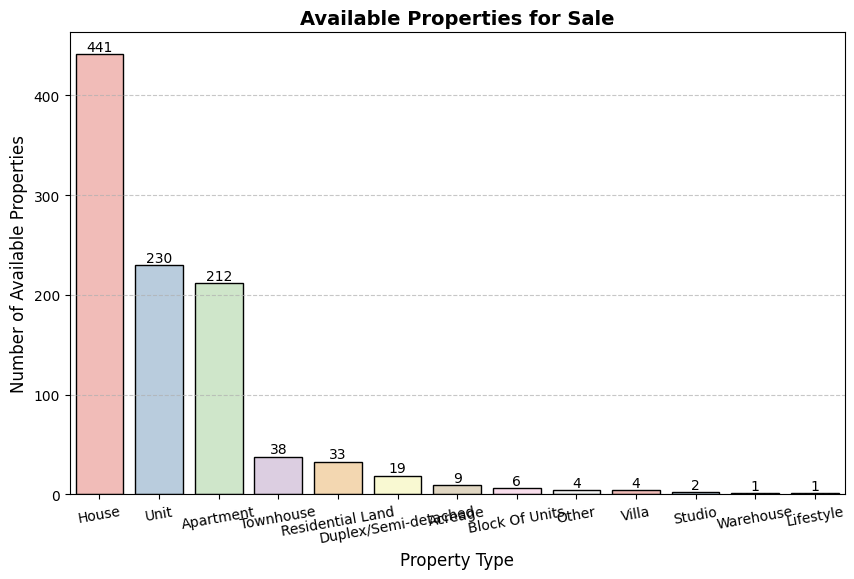

In [17]:
# Grouping and counting properties by type
df_oz_type_group = df_oz_clean['property_type'].value_counts().reset_index()
df_oz_type_group.columns = ['property_type', 'count']

# Plotting the number of available properties by type
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_oz_type_group,
    x='property_type',
    y='count',
    hue='property_type',  # Adding the hue parameter as suggested
    palette='Pastel1',
    edgecolor='black',
    dodge=False  # Ensures bars are not stacked
)
plt.title('Available Properties for Sale', fontsize=14, weight='bold', ha='center')
plt.xlabel('Property Type', fontsize=12)
plt.ylabel('Number of Available Properties', fontsize=12)

# Adding value labels to each bar
for index, row in df_oz_type_group.iterrows():
    plt.text(index, row['count'], row['count'], color='black', ha="center", va="bottom")

plt.xticks(rotation=10, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend([], [], frameon=False)  # Hides the legend
plt.show()


- As we can see that houses dominate the market with 441 listed properties, followed by units with 230 listings and apartments with 212 listings. Other property types make up only a minor fraction of the total listings.

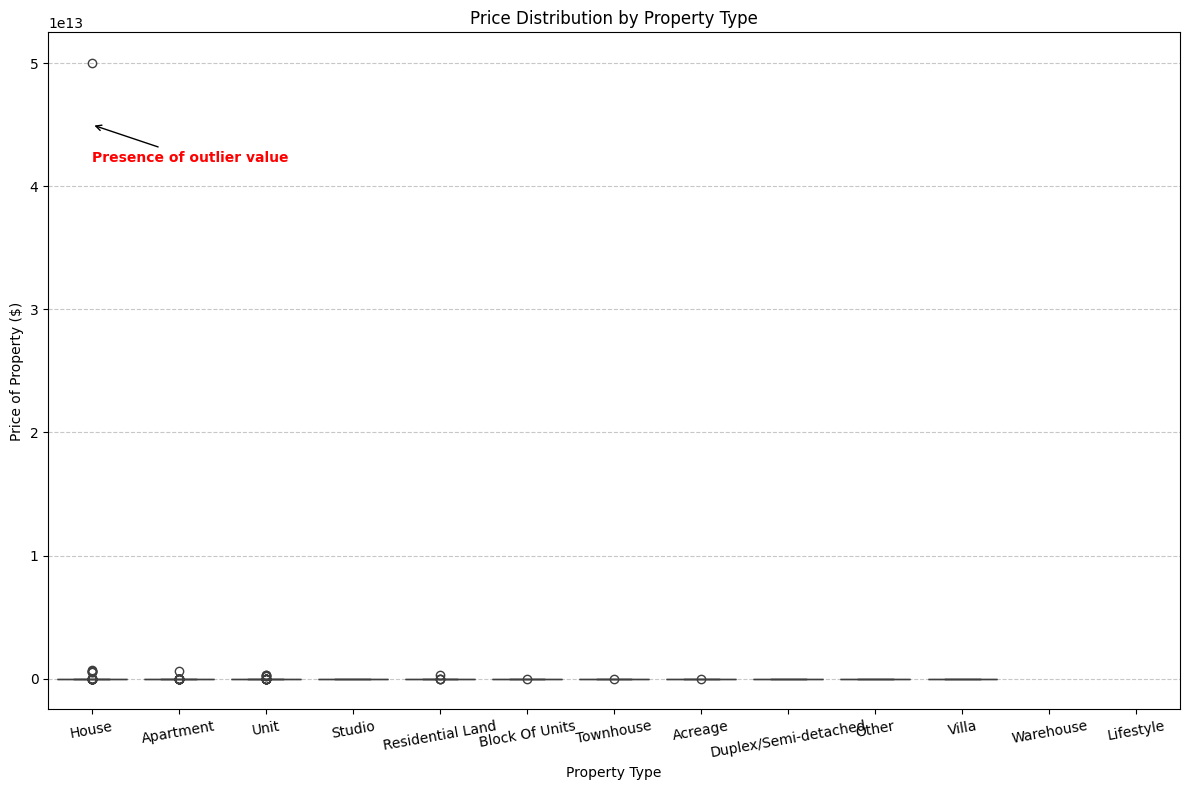

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_oz_clean, x='property_type', y='price')

#Adding annotation for the outlier in 'House' property type
plt.annotate(
    'Presence of outlier value',
    xy=('House', 4.5e+13),
    xytext=('House', 4.2e+13),
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    color='red',
    fontsize=10,
    fontweight='bold'
)

#Customizing plot appearance
plt.title('Price Distribution by Property Type')
plt.xlabel('Property Type')
plt.ylabel('Price of Property ($)')
plt.xticks(rotation=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


- As we can see, an outlier has significantly skewed the distribution of the variables. To address this, we will replace the outlier with a null value and generate a new plot to analyze the prices across different property types.

In [ ]:
#Calculate the outlier threshold using the IQR method
Q1 = df_oz_clean['price'].quantile(0.25)
Q3 = df_oz_clean['price'].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold = Q3 + 1.5 * IQR

#Create a new column 'new_price' with outliers replaced by NaN
df_oz_clean['new_price'] = df_oz_clean['price'].apply(lambda x: x if x < outlier_threshold else None)

- We will visualize the plot again after removing outliers.


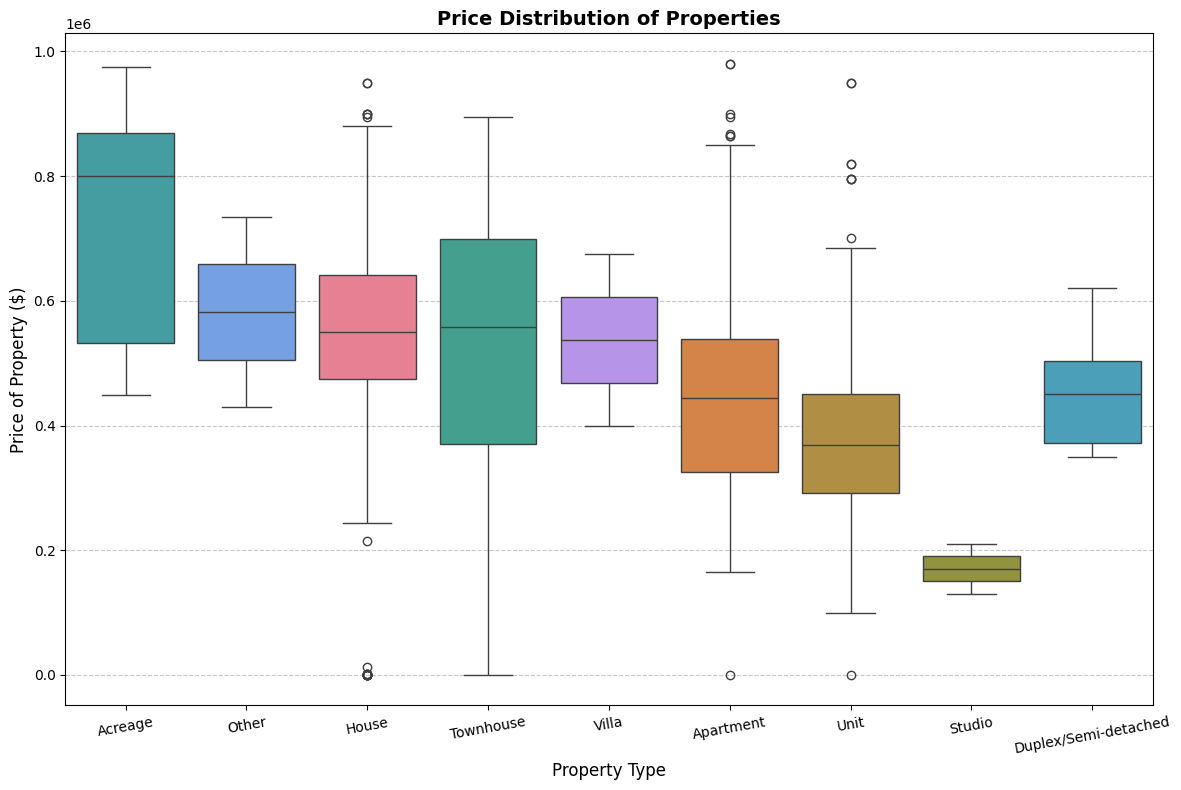

In [30]:
#Define the order of property types for the plot
level_order = ["Acreage", "Other", "House", "Townhouse", "Villa", "Apartment", "Unit", "Studio", "Duplex/Semi-detached"]

plt.figure(figsize=(12, 8))
sns.boxplot(
    data=df_oz_clean,
    x=pd.Categorical(df_oz_clean['property_type'], categories=level_order, ordered=True),
    y='new_price',
    hue=df_oz_clean['property_type'],
    dodge=False
)

plt.title('Price Distribution of Properties', fontsize=14, weight='bold')
plt.xlabel('Property Type', fontsize=12)
plt.ylabel('Price of Property ($)', fontsize=12)
plt.xticks(rotation=10, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.legend([], [], frameon=False)
plt.show()

- This plot shows the price distributions for various property types. Acreage properties have the highest median price, while studio properties are the least expensive. Townhouses exhibit significant price variability, as indicated by a wide interquartile range.

**5.  Bedroom availability**

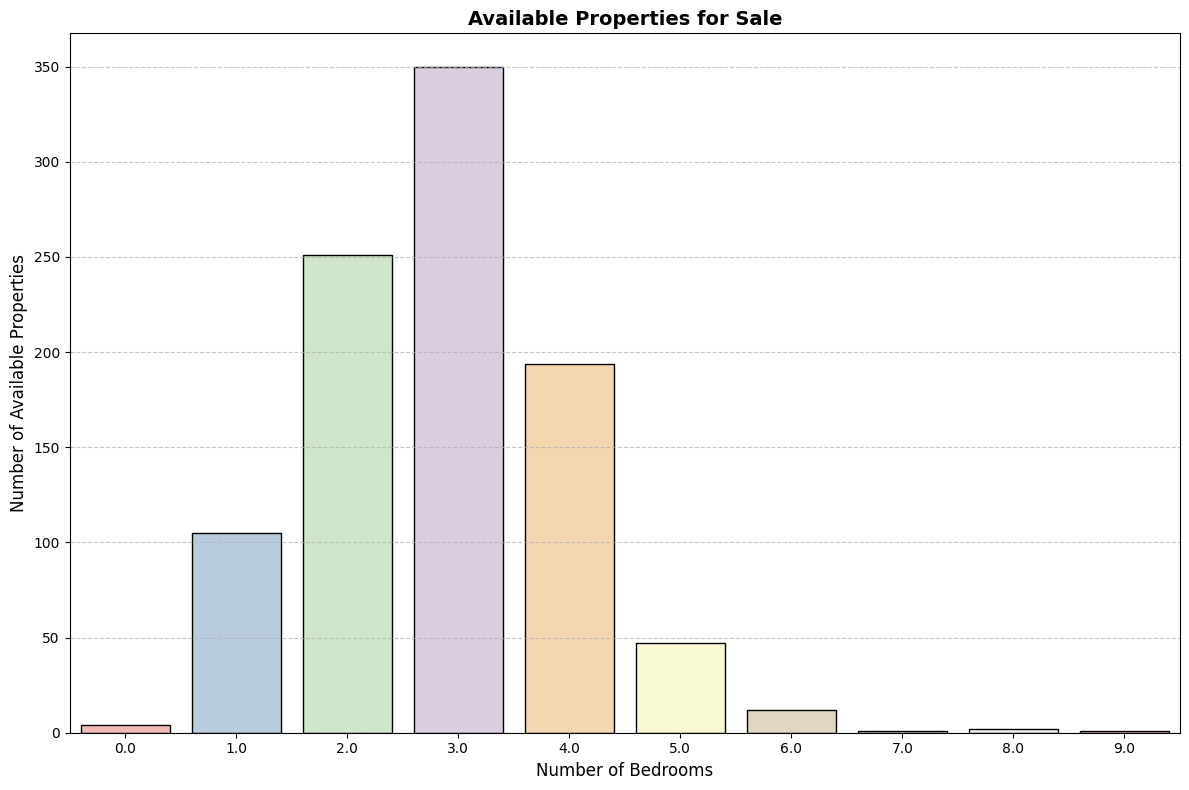

In [19]:
#Grouping and Counting Properties by Bedroom Count
df_group_bedrooms = df_oz_clean['bedroom_count'].value_counts().reset_index()
df_group_bedrooms.columns = ['bedroom_count', 'count']
df_group_bedrooms = df_group_bedrooms.sort_values(by='bedroom_count')

#Plotting the number of available properties by bedroom count
plt.figure(figsize=(12, 8))
sns.barplot(
    data=df_group_bedrooms,
    x='bedroom_count',
    y='count',
    hue='bedroom_count',
    palette='Pastel1',
    edgecolor='black',
    dodge=False
)

# Customizing plot appearance
plt.title('Available Properties for Sale', fontsize=14, weight='bold')
plt.xlabel('Number of Bedrooms', fontsize=12)
plt.ylabel('Number of Available Properties', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.legend([], [], frameon=False)
plt.show()


- The plot indicates that 3-bedroom properties are the most commonly available for sale, followed by 2-bedroom properties, with 4-bedroom properties coming next in availability.

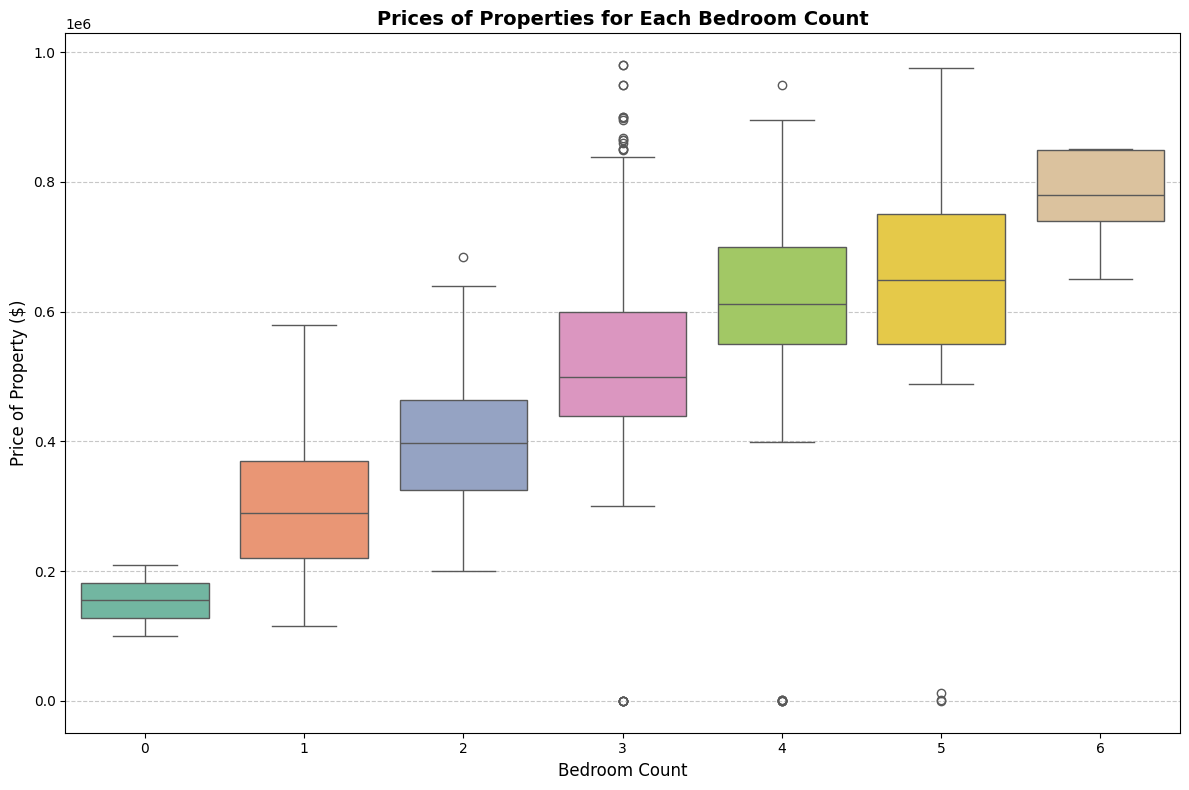

In [20]:
#Define the order of bedroom counts for the plot
bedroom_levels = [0, 1, 2, 3, 4, 5, 6]

#Plotting Prices of Properties by Bedroom Count
plt.figure(figsize=(12, 8))
sns.boxplot(
    data=df_oz_clean,
    x=pd.Categorical(df_oz_clean['bedroom_count'], categories=bedroom_levels, ordered=True),
    y='new_price',
    hue=df_oz_clean['bedroom_count'],
    palette='Set2',
    dodge=False
)

#Customizing plot appearance
plt.title('Prices of Properties for Each Bedroom Count', fontsize=14, weight='bold')
plt.xlabel('Bedroom Count', fontsize=12)
plt.ylabel('Price of Property ($)', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.legend([], [], frameon=False)
plt.show()

- The plot shows a consistent increase in median property prices as the number of bedrooms rises. Therefore, properties with more bedrooms tend to have higher prices.

**6. Bathroom availability**

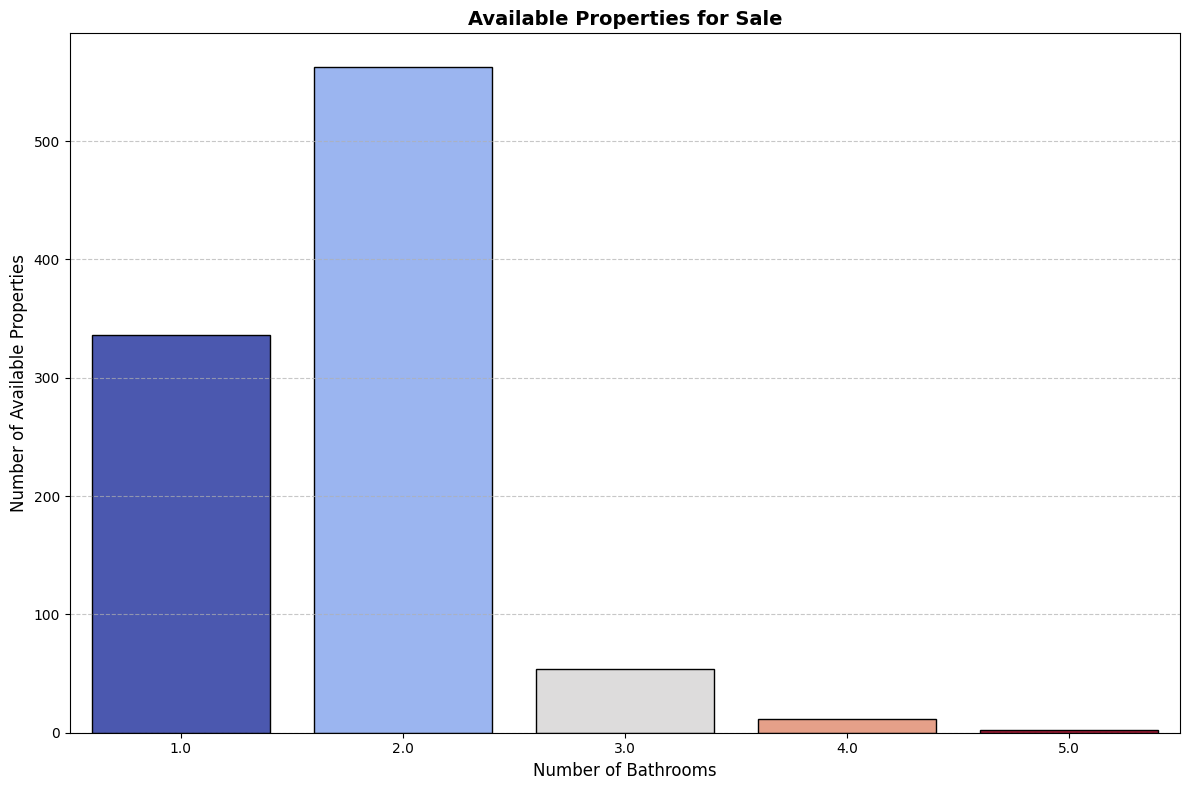

In [23]:
#Grouping and Counting Properties by Bathroom Count
df_group_bathrooms = df_oz_clean['bathroom_count'].value_counts().reset_index()
df_group_bathrooms.columns = ['bathroom_count', 'count']
df_group_bathrooms = df_group_bathrooms.sort_values(by='bathroom_count')

#Plotting the number of available properties by bathroom count
plt.figure(figsize=(12, 8))
sns.barplot(
    data=df_group_bathrooms,
    x='bathroom_count',
    y='count',
    hue='bathroom_count',
    palette='coolwarm',
    edgecolor='black',
    dodge=False
)

#Customizing plot appearance
plt.title('Available Properties for Sale', fontsize=14, weight='bold')
plt.xlabel('Number of Bathrooms', fontsize=12)
plt.ylabel('Number of Available Properties', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.legend([], [], frameon=False)
plt.show()


- As we can see that the majority of properties for sale have either 1 or 2 bathrooms, with 2-bathroom properties being the most common around 56 listings, followed by 1-bathroom properties with around 330 listings. Properties with more than 2 bathrooms represent only a small share of the total listings.

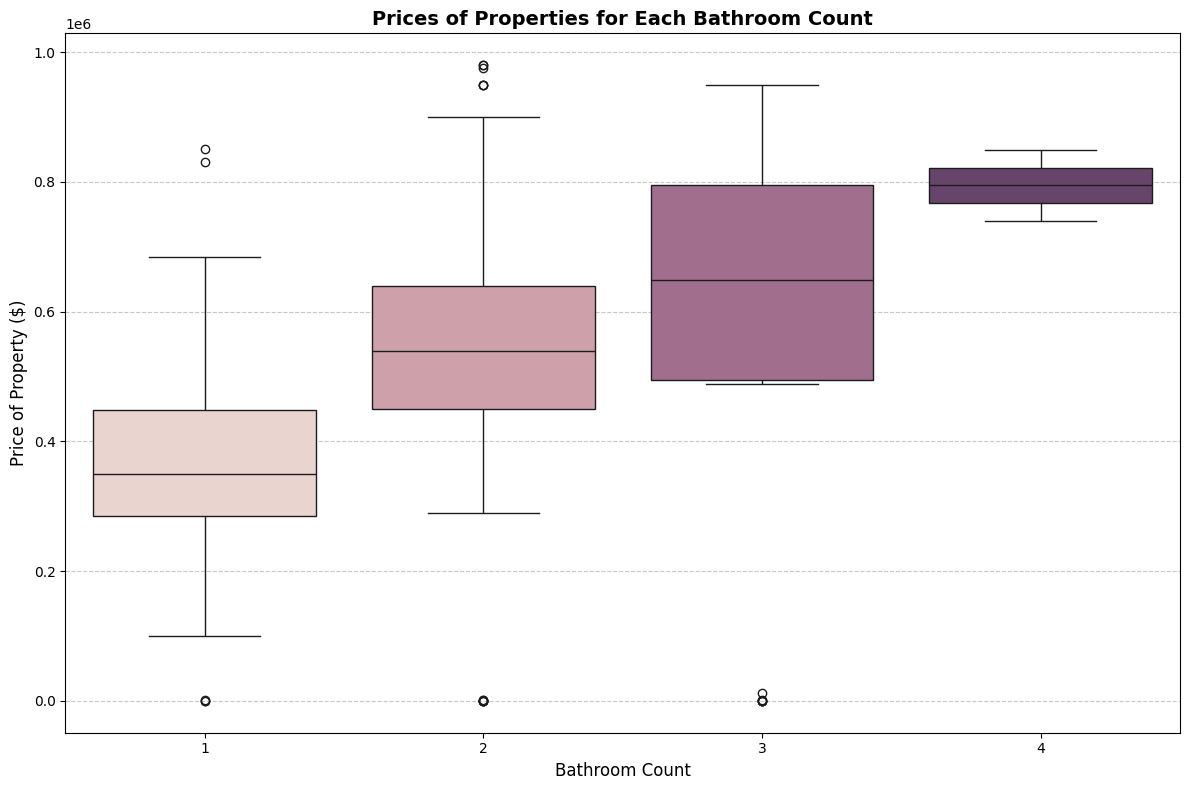

In [33]:
#Define the order of bathroom counts for the plot
bathroom_levels = [1, 2, 3, 4]

# Plotting Prices of Properties by Bathroom Count
plt.figure(figsize=(12, 8))
sns.boxplot(
    data=df_oz_clean,
    x=pd.Categorical(df_oz_clean['bathroom_count'], categories=bathroom_levels, ordered=True),
    y='new_price',
    hue=df_oz_clean['bathroom_count'],
    dodge=False
)

#Customizing plot appearance
plt.title('Prices of Properties for Each Bathroom Count', fontsize=14, weight='bold')
plt.xlabel('Bathroom Count', fontsize=12)
plt.ylabel('Price of Property ($)', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.legend([], [], frameon=False)
plt.show()


- Similar to what was observed for the relation between prices of bedrooms and the property, the properties associated with higher bathroom counts are also observed to report higher property prices.

**7. Parking space count**

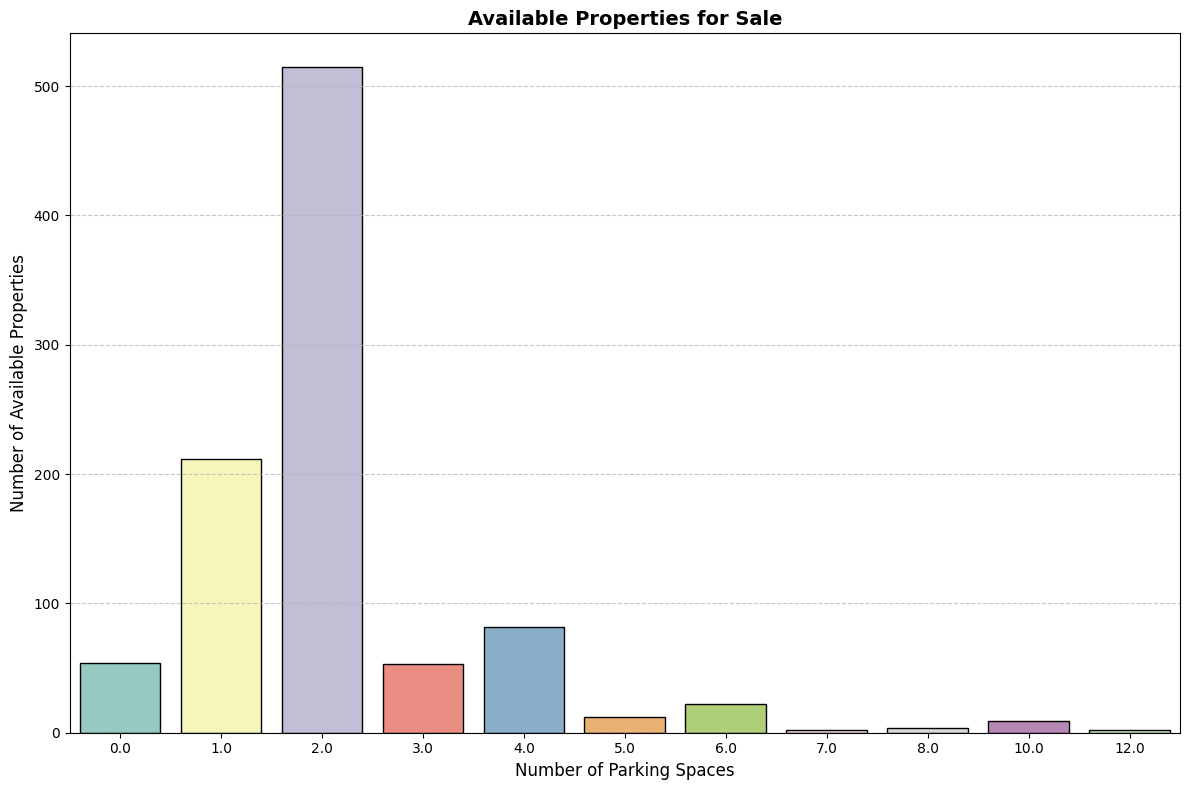

In [26]:
#Grouping and Counting Properties by Parking Count
df_group_park = df_oz_clean['parking_count'].value_counts().reset_index()
df_group_park.columns = ['parking_count', 'count']
df_group_park = df_group_park.sort_values(by='parking_count')

#Plotting the number of available properties by parking count
plt.figure(figsize=(12, 8))
sns.barplot(
    data=df_group_park,
    x='parking_count',
    y='count',
    hue='parking_count',
    palette='Set3',
    edgecolor='black',
    dodge=False
)

# Customizing plot appearance
plt.title('Available Properties for Sale', fontsize=14, weight='bold')
plt.xlabel('Number of Parking Spaces', fontsize=12)
plt.ylabel('Number of Available Properties', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.legend([], [], frameon=False)
plt.show()


- As we can see, properties with 2 parking space counts are the most widely available among the listings. Properties with parking space counts higher than 2 constitute a small part of the entire population of listings

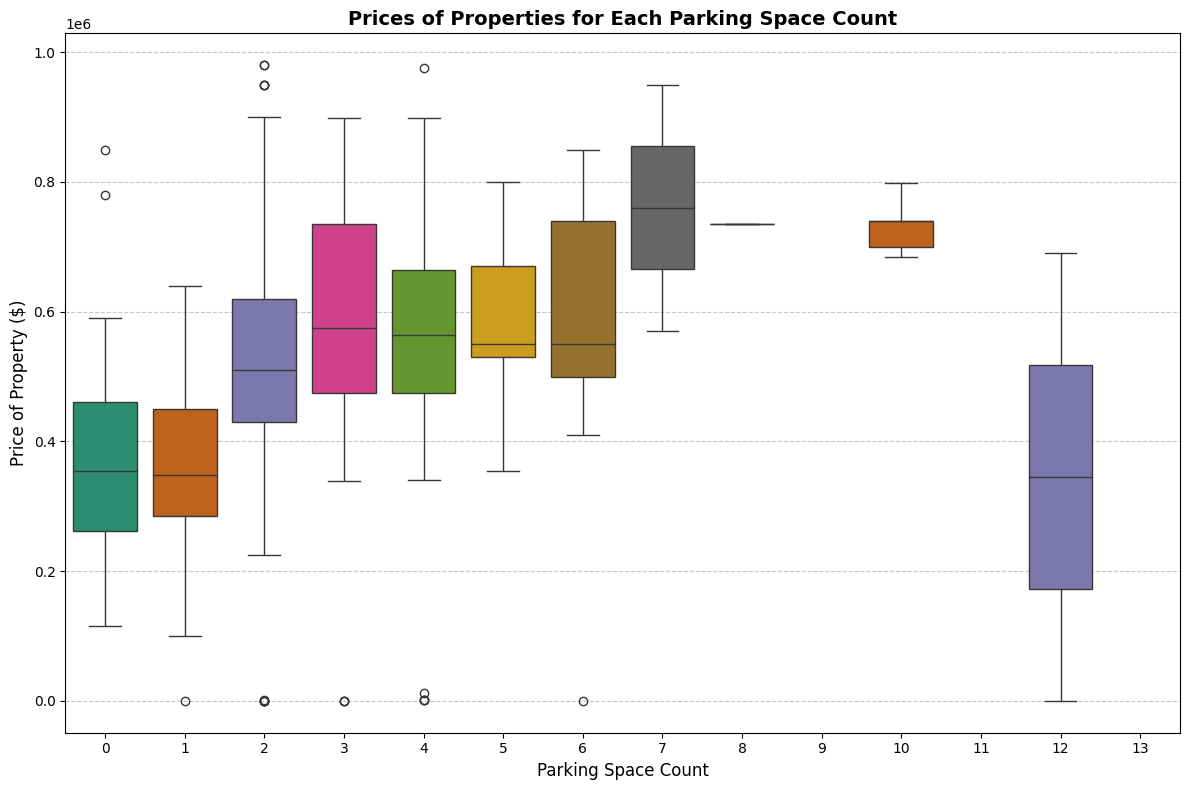

In [28]:
#Define the order of parking counts for the plot
parking_levels = [0, 1, 2, 3, 4, 5, 6, 7,8, 9, 10,11 ,12,13]

#Plotting Prices of Properties by Parking Space Count
plt.figure(figsize=(12, 8))
sns.boxplot(
    data=df_oz_clean,
    x=pd.Categorical(df_oz_clean['parking_count'], categories=parking_levels, ordered=True),
    y='new_price',
    hue=df_oz_clean['parking_count'],
    palette='Dark2',
    dodge=False

#Customizing plot appearance
plt.title('Prices of Properties for Each Parking Space Count', fontsize=14, weight='bold')
plt.xlabel('Parking Space Count', fontsize=12)
plt.ylabel('Price of Property ($)', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.legend([], [], frameon=False)
plt.show()


- As we can see, there is a gradual increase in the median prices of the properties as the available parking space counts increase. However, there appears to be an outlier in the above analysis as the property with parking space counts of 12 are observed to report lower price as compared to properties with lower values of parking space counts. However, this could be attributed to the low population of properties with 12 parking space counts

**8. Correlation plot**


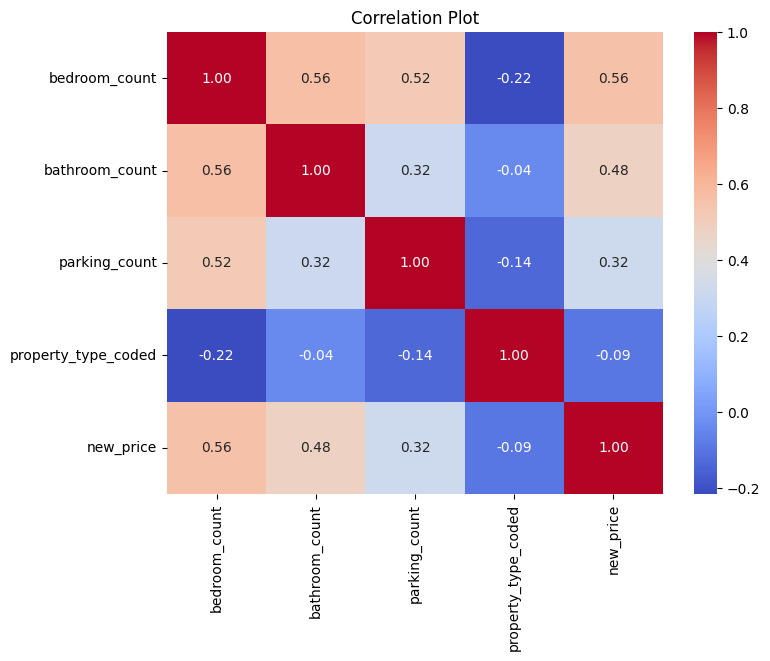

In [35]:
#Selecting relevant columns from the dataframe
df_oz_num = df_oz_clean[["property_type", "building_size", "land_size", "preferred_size",
                         "bedroom_count", "bathroom_count", "parking_count", "new_price"]].copy()  # Use .copy() to avoid the warning

#Encoding property_type as numerical values using a mapping
property_type_mapping = {
    "House": 1, "Apartment": 2, "Unit": 3, "Studio": 4, "Residential Land": 5,
    "Block Of Units": 6, "Townhouse": 7, "Acreage": 8, "Duplex/Semi-detached": 9,
    "Other": 10, "Villa": 11, "Warehouse": 12, "Lifestyle": 13
}

df_oz_num.loc[:, 'property_type_coded'] = df_oz_num['property_type'].map(property_type_mapping)

#Selecting relevant columns and dropping missing values
df_oz_num = df_oz_num[["bedroom_count", "bathroom_count", "parking_count", "property_type_coded", "new_price"]].dropna()
correlation_matrix = df_oz_num.corr()

#Creating the correlation plot using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Plot")
plt.show()


- As we can see from the correlation plot, the correlation plot shows that the number of bedrooms has a 56% correlation with property prices, followed by the number of bathrooms at 48%, and parking count at 32%.

